In [1]:
from datasets import load_dataset
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

ds = load_dataset("mandarjoshi/trivia_qa", "rc")['validation']

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
ds[12]

{'question': 'Which volcano in Tanzania is the highest mountain in Africa?',
 'question_id': 'tc_217',
 'question_source': 'http://www.triviacountry.com/',
 'entity_pages': {'doc_source': ['TagMe', 'TagMe'],
  'filename': ['Tanzania.txt', 'Mount_Kilimanjaro.txt'],
  'title': ['Tanzania', 'Mount Kilimanjaro'],
  'wiki_context': ['Tanzania,This approximates the Kiswahili pronunciation. However, is also heard in English. officially the United Republic of Tanzania (), is a large country in Eastern Africa within the African Great Lakes region. Parts of the country are in Southern Africa. It is bordered by Kenya and Uganda to the north; Rwanda, Burundi, and the Democratic Republic of the Congo to the west; Zambia, Malawi, and Mozambique to the south; and by the Indian Ocean to the east. Kilimanjaro, Africa\'s highest mountain, is in northeastern Tanzania.\n\nTanzania\'s population of 51.82 million (2014)  is diverse, composed of several ethnic, linguistic, and religious groups. Tanzania is a

In [3]:
def simplify(example):
    return {
        "id": example["question_id"],
        "question": example["question"],
        "normalized_aliases": example["answer"]["normalized_aliases"]
    }

simplified_ds = ds.map(simplify, remove_columns=ds.column_names)
print(simplified_ds[1])

{'question': 'Which Lloyd Webber musical premiered in the US on 10th December 1993?', 'id': 'tc_33', 'normalized_aliases': ['sunset boulevard', 'sunset bulevard', 'west sunset boulevard', 'sunset blvd']}


In [4]:
trivia_sample = simplified_ds.shuffle(seed=42).select(range(1000))
trivia_sample[0]

{'question': 'What general name is given to a rotating star which emits a regular beat of radiation?',
 'id': 'sfq_178',
 'normalized_aliases': ['yukon optics', 'beltex optics', 'pulsar']}

In [4]:
trivia_sample.to_json("trivia_sample_raw.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

380799

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

# Classifying questions using the DSPy program

## Loading the model

In [5]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)
dspy.configure(lm=model)

## Helper functions

In [6]:
def run_batch(batch, class_to_use):
    results = []
    for request in batch["question"]:
        try:
            result = class_to_use(request=request)
            results.append({
                "category": result.category,
                "judgment": result.judgment,
                "reasoning": getattr(result, "reasoning", "")
            })
        except Exception as e:
            results.append({
                "category": "error",
                "judgment": "error",
                "reasoning": "error"
            })
    return {
        "category": [r["category"] for r in results],
        "judgment": [r["judgment"] for r in results],
        "reasoning": [r["reasoning"] for r in results]
    }



def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

def collect_thinking_streaming(loaded_model, output_path):
    history_data = loaded_model.history
    print(f'The current length of history is {len(history_data)}.')

    with open(output_path, 'w', encoding='utf-8') as f:
        for record in history_data:
            thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
            json.dump({"thinking": thinking}, f)
            f.write('\n')


def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"Length mismatch：'{column_name}' The column length is {len(values)}, but the dataset has {len(dataset)} samples.")
        dataset = dataset.add_column(column_name, values)

    return dataset

## Loading the DSPy program from Exp 2

In [7]:
loaded_dspy_program = dspy.load("../Reproductivity/dspy_program/")
# Encapsule the loaded program into the batch running function
wrapped_batch = partial(run_batch, class_to_use=loaded_dspy_program)

In [8]:
# batch parameters
batch_size = 5
num_samples = len(trivia_sample)
batches = [trivia_sample.select(range(i, min(i + batch_size, num_samples))) for i in range(0, num_samples, batch_size)]

# Initialize a dict of outputs with empty lists using designated keys
all_outputs = {"category": [], "judgment": [], "reasoning": []}

# tqdm progress bar
for batch in tqdm(batches, desc="Running DSPy classification"):
    out = wrapped_batch(batch)
    for key in all_outputs:
        all_outputs[key].extend(out[key])

Running DSPy classification: 100%|██████████| 200/200 [2:04:48<00:00, 37.44s/it]  


In [9]:
# Integrate outputs into the original dataset (copy)
annotated_dataset = add_columns_to_dataset(trivia_sample, all_outputs)

# Create the UND subset
underspecified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "underspecified"
)

# Create the FS subset
fully_specified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "fully specified"
)

# The size of subsets
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("classified_TriviaQA_sample_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("classified_TriviaQA_sample_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("classified_TriviaQA_sample_FS.jsonl", orient="records", lines=True)

Flattening the indices:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Underspecified samples: 98
Fully specified samples: 902


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

721905

In [10]:
annotated_dataset[0]

{'question': 'What general name is given to a rotating star which emits a regular beat of radiation?',
 'id': 'sfq_178',
 'normalized_aliases': ['yukon optics', 'beltex optics', 'pulsar'],
 'category': 'fully specified',
 'judgment': 'fully specified',
 'reasoning': 'This question is fully specified because it asks for a well-defined astronomical term that describes a specific type of rotating star emitting regular radiation pulses. The referent is unambiguous, and the description aligns with the scientific definition of a "pulsar," a neutron star that emits regular electromagnetic radiation pulses. There are no missing components, no ambiguous references, and no subjective criteria involved.'}

In [11]:
# Collect thinking
think_list = collect_thinking(model)
print(f"The number of thinking pieces is {len(think_list)}.")
think_df = pd.DataFrame(think_list)
think_df.to_csv('think_TriviaQA_sample.csv')

collect_thinking_streaming(model, "think_TriviaQA_sample.jsonl")

The current length of history is 1042.
The number of thinking pieces is 1042.
The current length of history is 1042.


In [12]:
df = pd.read_json("classified_TriviaQA_sample_all.jsonl", lines=True)
df.to_csv('classified_TriviaQA_sample_all.csv')
df

,question,id,normalized_aliases,category,judgment,reasoning
0,What general name is given to a rotating star ...,sfq_178,"[yukon optics, beltex optics, pulsar]",fully specified,fully specified,This question is fully specified because it as...
1,"""Which Gilbert and Sullivan operetta is sub ti...",sfq_11822,"[ruddigore, ruddigore witch s curse, rudigore,...",fully specified,fully specified,This question is fully specified because it re...
2,Which English cricketer had figures for bowlin...,sfq_17752,"[james laker, jim laker]",fully specified,fully specified,This question is fully specified because it re...
3,Wolf Mankowitz wrote the 1953 novel ‘A Kid For...,qb_2689,"[farthings, farthing, farthing disambiguation,...",Undetermined lexicons or references,underspecified,The request is underspecified because the phra...
4,Who is the patron saint of dancers?,sfq_6199,"[saint crescentia, saint vitus, vitus, s vito,...",fully specified,fully specified,This question is fully specified because it as...
...,...,...,...,...,...,...
995,"In what French region would you find Omaha, Ju...",jp_159,"[normandy france, normandy, normandy region]",fully specified,fully specified,This question is fully specified because it re...
996,Who famously had children with both Julius Cae...,jp_2596,"[keeuopatrai, queen cleopatra vii, queen cleop...",fully specified,fully specified,This question is fully specified because it re...
997,Which band released the albums Sheer Heart Att...,sfq_20578,"[quene, queen disambiguation, queen album, que...",fully specified,fully specified,This question is fully specified because it re...
998,In which 1984 film did Tom Hanks fall in love ...,qf_2678,"[splash american band, splash band, splash alb...",fully specified,fully specified,This question is fully specified because it re...


# QA implementations

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="classified_TriviaQA_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="classified_TriviaQA_sample_FS.jsonl",
    split="train"
)

## Loading GPT for short QA

In [3]:
from openai import OpenAI

client = OpenAI(
    api_key="",
    base_url="https://api.openai.com/v1"
) # Delete when sharing

In [4]:
def ask_short_answer(question, client, model="gpt-4o-2024-11-20", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with concise responses. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return ["[Error]: Max retries exceeded"]

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

In [6]:
def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=5, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

## Implementations

In [7]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


In [9]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 181/181 [06:59<00:00,  2.32s/it]


In [10]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])

qa_underspecified.to_json("TriviaQA_UND_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

83301

In [11]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])

qa_fully_specified.to_json("TriviaQA_FS_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

757596

In [14]:
df = pd.read_json("TriviaQA_UND_qa_gpt.jsonl", lines=True)
df.to_csv('TriviaQA_UND_qa_gpt.csv')

df = pd.read_json("TriviaQA_FS_qa_gpt.jsonl", lines=True)
df.to_csv('TriviaQA_FS_qa_gpt.csv')

# Evaluations

In [32]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="TriviaQA_UND_qa_gpt.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="TriviaQA_FS_qa_gpt.jsonl",
    split="train"
)

## Squad EM + F1

In [33]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="TriviaQA_FS_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["normalized_aliases"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 79.38
F1 Score: 86.92


In [34]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="TriviaQA_UND_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["normalized_aliases"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 68.37
F1 Score: 78.39


In [35]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="normalized_aliases"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [36]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("TriviaQA_UND_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

84996

In [37]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("TriviaQA_FS_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

772690

In [38]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 68.37
UND F1 Score (avg): 78.39
FS Exact Match (avg): 79.38
FS F1 Score (avg): 86.95
F1: t=2.249, p=0.0265
EM: t=2.243, p=0.0269


In [2]:
UND_full = load_dataset(
    "json",
    data_files="TriviaQA_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="TriviaQA_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
df = pd.read_json("TriviaQA_UND_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('TriviaQA_UND_qa_gpt_with_squad_scores.csv')

df = pd.read_json("TriviaQA_FS_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('TriviaQA_FS_qa_gpt_with_squad_scores.csv')

In [3]:
print(f'gpt_4o TriviaQA NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o TriviaQA NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o TriviaQA NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o TriviaQA NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o TriviaQA NQ UND qa EM SD: 0.46504199449411593
gpt_4o TriviaQA NQ FS qa EM SD: 0.40458189638495196
gpt_4o TriviaQA NQ UND qa F1 SD: 0.3622724129981127
gpt_4o TriviaQA NQ FS qa F1 SD: 0.2936539771078576


In [4]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [5]:
welch_df(98, np.std(UND_full["em"]), 902, np.std(FS_full["em"]))

113.52656977914847

In [6]:
welch_df(98, np.std(UND_full["f1"]), 902, np.std(FS_full["f1"]))

111.28240242834372

## Visualization

In [41]:
print("FS F1:", set(FS_f1_list))
print("UND F1:", min(UND_f1_list), max(UND_f1_list))

FS F1: {0.5714285714285715, 1.0, 0.6666666666666666, 0.0, 0.5, 0.3076923076923077, 0.8, 0.7272727272727272, 0.2222222222222222, 0.75, 0.25, 0.18181818181818182, 0.1935483870967742, 0.3636363636363636, 0.6, 0.5454545454545454, 0.14285714285714285, 0.15384615384615385, 0.2, 0.23529411764705882, 0.13333333333333333, 0.19999999999999998, 0.7777777777777778, 0.2857142857142857, 0.28571428571428575, 0.8571428571428571, 0.33333333333333337, 0.8461538461538461, 0.4, 0.888888888888889, 0.9333333333333333, 0.7499999999999999}
UND F1: 0.0 1.0


In [42]:
import numpy as np
q1 = np.percentile(FS_f1_list, 25)
q2 = np.percentile(FS_f1_list, 50)
q3 = np.percentile(FS_f1_list, 75)
print(f"Q1={q1:.2f}, Median={q2:.2f}, Q3={q3:.2f}")

Q1=1.00, Median=1.00, Q3=1.00


In [ ]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset")
plt.tight_layout()
plt.savefig("TriviaQA_f1_boxplot_gpt.png")
plt.close()

In [50]:
df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("gpt-4o-2024-11-20 Exact Match Rate by Subset (± CI)")
plt.tight_layout()
plt.savefig("TriviaQA_em_barplot_gpt.png",dpi=300)
plt.close()

/scratch-local/yhuang.13017567/ipykernel_3295286/1073783778.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.13017567/ipykernel_3295286/1073783778.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


In [47]:
# 设置学术风格
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(6.5, 4.5))

# Violin plot 只显示分布，不显示 quartile
sns.violinplot(
    x="Subset", y="F1", data=df_f1,
    palette="Set2", inner=None, cut=0
)

# 叠加 boxplot 显示中位数和 IQR，透明一点避免遮住 violin
sns.boxplot(
    x="Subset", y="F1", data=df_f1,
    width=0.2, showcaps=True, boxprops={'facecolor':'white', 'zorder':2},
    whiskerprops={'linewidth':1.5}, medianprops={'color':'black', 'linewidth':2},
    showfliers=False
)

# 叠加 stripplot 显示原始点（可选）
sns.stripplot(
    x="Subset", y="F1", data=df_f1,
    color='black', size=2.5, jitter=True, alpha=0.4
)

plt.ylim(-0.05, 1.05)
plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset", fontsize=14)
plt.xlabel("")
plt.ylabel("F1 Score", fontsize=12)

plt.tight_layout()
plt.savefig("fig_gpt4o_f1_by_subset.png", dpi=300) 
plt.show()

/scratch-local/yhuang.13017567/ipykernel_3295286/3074641432.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch-local/yhuang.13017567/ipykernel_3295286/3074641432.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


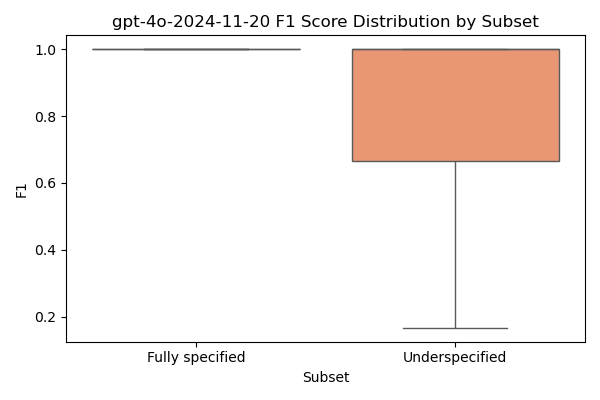

In [40]:
from IPython.display import Image
Image("TriviaQA_f1_boxplot_gpt.png")

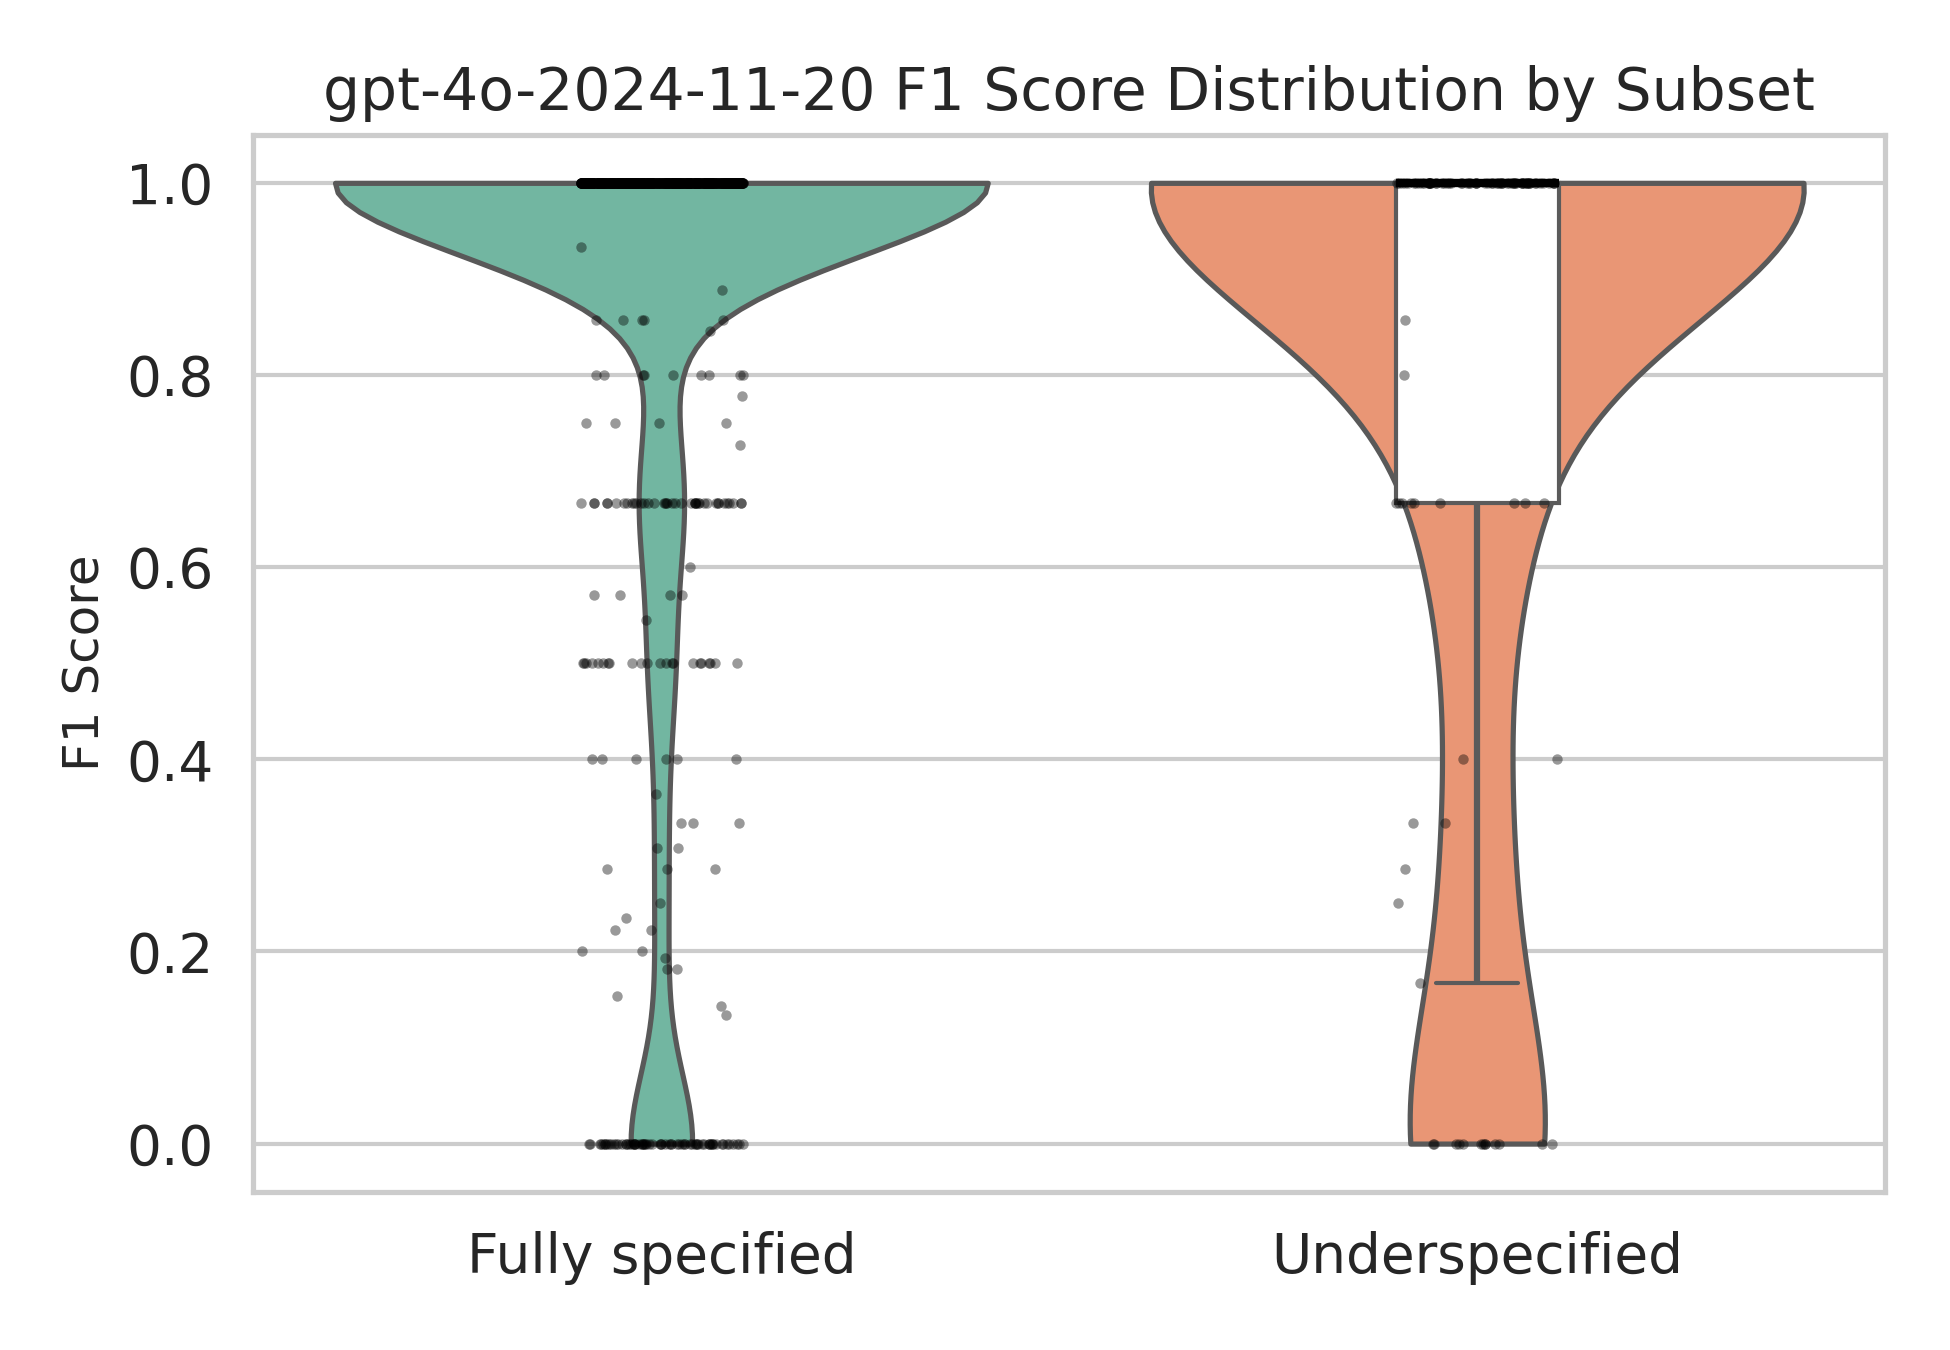

In [48]:
from IPython.display import Image
Image("fig_gpt4o_f1_by_subset.png")

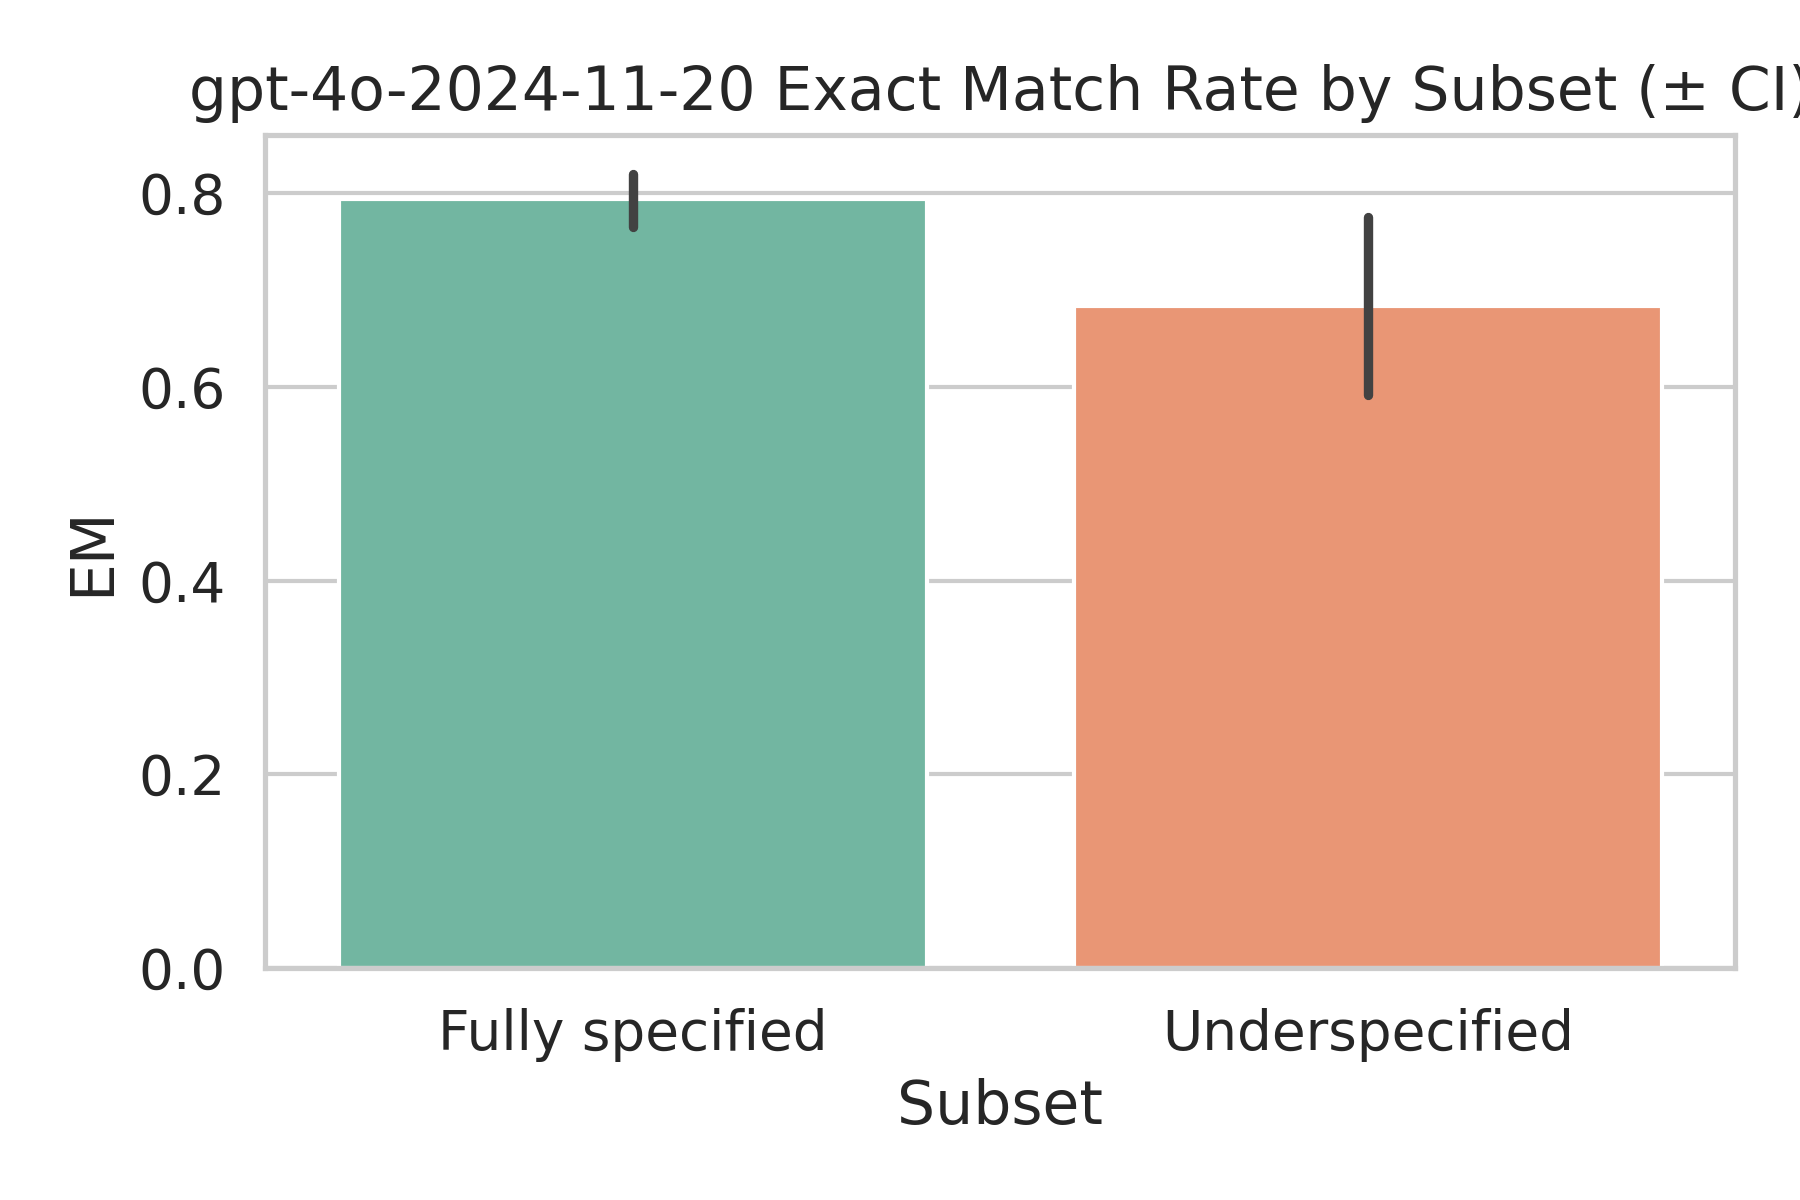

In [51]:
Image("TriviaQA_em_barplot_gpt.png")